<a href="https://colab.research.google.com/github/musicjae/cs231n/blob/master/assignment2/Dropout_summary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 마운트

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = 'Colab Notebooks/cs231n/assignments/assignment2'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# this downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/cs231n/assignments/assignment2/cs231n/datasets
/content


# 데이터 로드

In [6]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

=========== You can safely ignore the message below if you are NOT working on ConvolutionalNetworks.ipynb ===========
	You will need to compile a Cython extension for a portion of this assignment.
	The instructions to do this will be given in a section of the notebook below.
	There will be an option for Colab users and another for Jupyter (local) users.


In [7]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_train:  (49000, 3, 32, 32)
y_train:  (49000,)
X_val:  (1000, 3, 32, 32)
y_val:  (1000,)
X_test:  (1000, 3, 32, 32)
y_test:  (1000,)


# Dropout  


바닐라 드롭아웃이 가진 바람직하지 못한 속성은 우리가 테스트 시간에 확률 p에 의한 활성화를 스케일해주어야 한다는 것이다. 테스트 시간 수행능력이 매우 중요하기 때문에, 테스트 시간에 순전파를 건드리지 않으면서, (학습 시간에 스케일을 수행하는) inverted 드롭아웃을 사용하는 것이 선호된다.   
  
    
  

게다가, 이것은 예측 코드가 네가 드롭아웃을 적용하는 곳을 수정하기로 결정할 때, 가만히 둘 수 있는 매력적인 속성을 갖는다. 이 거꾸로된 드롭아웃은 다음과 같다:

## 1. 드롭아웃의 순전파

Performs the forward pass for (inverted) dropout.  

**Inputs:**

- **x**: Input data, of any shape

- **dropout_param**: A dictionary with the following keys:

- **p**: Dropout parameter. We keep each neuron output with probability p.

- **mode**: 'test' or 'train'. If the mode is train, then perform dropout; if the mode is test, then just return the input.

- **seed:** Seed for the random number generator. Passing seed makes this function deterministic, which is needed for gradient checking but not in real networks.

**Outputs:** 

- **out:** Array of the same shape as x.  
  
  
- **cache:** tuple (dropout_param, mask). In training mode, mask is the dropout mask that was used to multiply the input; in test mode, mask is None.  
  


- **NOTE:** Please implement **inverted** dropout, not the vanilla version of dropout. See http://cs231n.github.io/neural-networks-2/#reg for more details.  
  


- **NOTE 2:** Keep in mind that p is the probability of keep a neuron output; this might be contrary to some sources, where it is referred to as the probability of dropping a neuron output.

In [27]:
from builtins import range
import numpy as np


def dropout_forward(x, dropout_param):

    p, mode = dropout_param["p"], dropout_param["mode"]
    if "seed" in dropout_param:
        np.random.seed(dropout_param["seed"])

    mask = None
    out = None

    if mode == "train":
        #######################################################################
        # TODO: Implement training phase forward pass for inverted dropout.   #
        # Store the dropout mask in the mask variable. (위 링크 참고)            #
        #######################################################################
        mask = (np.random.rand(*x.shape) < p) / p # 애스테리카는 튜플을 unpack 하기 위해 사용
        out = x*mask
        #######################################################################
    elif mode == "test":
        #######################################################################
        # TODO: Implement the test phase forward pass for inverted dropout.   #
        #######################################################################
        out = x
        #######################################################################

    cache = (dropout_param, mask)
    out = out.astype(x.dtype, copy=False)

    return out, cache

In [28]:
np.random.seed(231)
x = np.random.randn(500, 500) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())
  print()

Running tests with p =  0.25
Mean of input:  10.000207878477502
Mean of train-time output:  10.014059116977283
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.749784
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.4
Mean of input:  10.000207878477502
Mean of train-time output:  9.977917658761159
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.600796
Fraction of test-time output set to zero:  0.0

Running tests with p =  0.7
Mean of input:  10.000207878477502
Mean of train-time output:  9.987811912159426
Mean of test-time output:  10.000207878477502
Fraction of train-time output set to zero:  0.30074
Fraction of test-time output set to zero:  0.0



## 2. 드롭아웃의 역전파

Perform the backward pass for (inverted) dropout.  
  
  

**Inputs:**

- **dout:** Upstream derivatives, of any shape  
  

- **cache:** (dropout_param, mask) from dropout_forward.


In [19]:
def dropout_backward(dout, cache):
   
    dropout_param, mask = cache
    mode = dropout_param["mode"]

    dx = None
    if mode == "train":
        #######################################################################
        # TODO: Implement training phase backward pass for inverted dropout   #
        #######################################################################
        dx = dout*mask
        #######################################################################
    elif mode == "test":
        dx = dout
    return dx

In [20]:
np.random.seed(231)
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  5.44560814873387e-11


## Inline Question 1:
What happens if we do not divide the values being passed through inverse dropout by `p` in the dropout layer? Why does that happen?

## Answer:

바닐라 드롭아웃은 현실적으로 사용하기 힘들다. 데이터 양이 클 경우에 매우 많은 연산 수행을 요구하기 때문이다. 그래서 그 대안으로 inverted 드롭아웃을 사용하는 것이다. 여기서 학습 시간에 p를 나눠주는 이유는 바닐라 드롭아웃 때 테스트 타임에서 p를 곱해주던 것을 하지 않는 대신에, 학습 시간 때 p를 나눠주는 방법을 택했기 때문이다. 즉, 학습 시간 때 스케일링을 미리 처리해주는 것이다.  
  
   만약 이것이 미리 처리되지 않는다면, 위 forward pass 시 산출되는 결과 중 Mean of train-time output가 (p를 나눠준 경우보다) 상대적으로 낮을 것이다. p은 보통 1 보다 작은 수이니까 이것을 나누지 않은 산출값은 이것을 나눈 산출값 보다 클 수 밖에 없다.

## 3. 드롭아웃이 포함된 전연결 신경망

In [29]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [1, 0.75, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)
  
  # Relative errors should be around e-6 or less; Note that it's fine
  # if for dropout=1 you have W2 error be on the order of e-5.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

Running check with dropout =  1
Initial loss:  2.3004790897684924
W1 relative error: 1.48e-07
W2 relative error: 2.21e-05
W3 relative error: 3.53e-07
b1 relative error: 5.38e-09
b2 relative error: 2.09e-09
b3 relative error: 5.80e-11

Running check with dropout =  0.75
Initial loss:  2.302371489704412
W1 relative error: 1.90e-07
W2 relative error: 4.76e-06
W3 relative error: 2.60e-08
b1 relative error: 4.73e-09
b2 relative error: 1.82e-09
b3 relative error: 1.70e-10

Running check with dropout =  0.5
Initial loss:  2.3042759220785896
W1 relative error: 3.11e-07
W2 relative error: 1.84e-08
W3 relative error: 5.35e-08
b1 relative error: 5.37e-09
b2 relative error: 2.99e-09
b3 relative error: 1.13e-10



## 4. 정규화 실험

우리는 500 개의 예에 대한 한 쌍의 복층 신경망을 훈련시킬 것이다. 하나는 드롭아웃을 사용하지 않을 것이고, 다른 하나는 p = 0.75로 사용할 것이다. 우리는 시간이 지남에 따라 변화하는 두 개의 신경망의 트레이닝, 검증 정확도를 시각화할 것이다.

In [32]:
np.random.seed(231)
num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.75]
for dropout in dropout_choices:
  model = FullyConnectedNet([500], dropout=dropout)
  print(dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

0
(Iteration 1 / 125) loss: 7.856643
(Epoch 0 / 25) train acc: 0.274000; val_acc: 0.192000
(Epoch 1 / 25) train acc: 0.410000; val_acc: 0.263000
(Epoch 2 / 25) train acc: 0.518000; val_acc: 0.269000
(Epoch 3 / 25) train acc: 0.550000; val_acc: 0.248000
(Epoch 4 / 25) train acc: 0.684000; val_acc: 0.297000
(Epoch 5 / 25) train acc: 0.758000; val_acc: 0.292000
(Epoch 6 / 25) train acc: 0.782000; val_acc: 0.266000
(Epoch 7 / 25) train acc: 0.860000; val_acc: 0.239000
(Epoch 8 / 25) train acc: 0.862000; val_acc: 0.284000
(Epoch 9 / 25) train acc: 0.896000; val_acc: 0.279000
(Epoch 10 / 25) train acc: 0.904000; val_acc: 0.266000
(Epoch 11 / 25) train acc: 0.942000; val_acc: 0.303000
(Epoch 12 / 25) train acc: 0.952000; val_acc: 0.299000
(Epoch 13 / 25) train acc: 0.946000; val_acc: 0.289000
(Epoch 14 / 25) train acc: 0.952000; val_acc: 0.269000
(Epoch 15 / 25) train acc: 0.968000; val_acc: 0.301000
(Epoch 16 / 25) train acc: 0.986000; val_acc: 0.315000
(Epoch 17 / 25) train acc: 0.988000; v

Plot train and validation accuracies of the two models


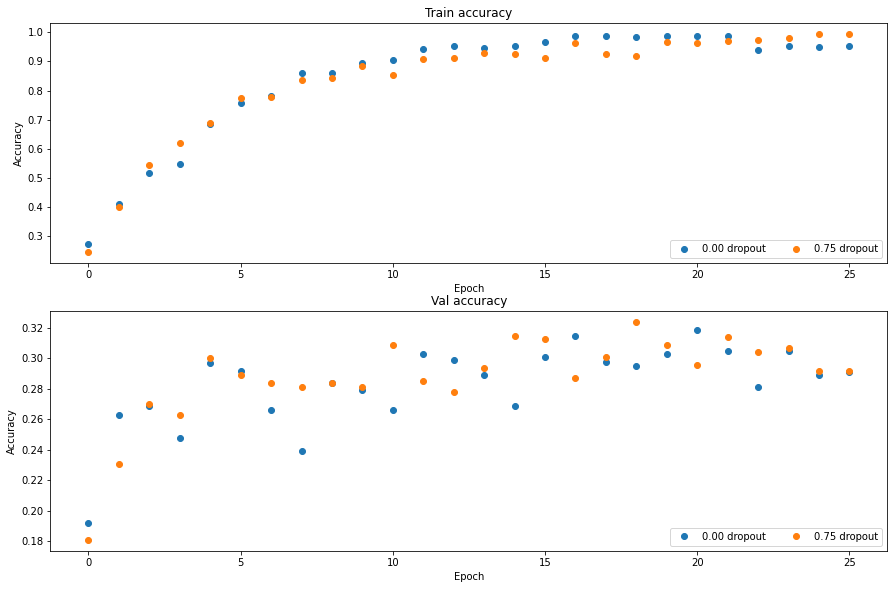

In [33]:
train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()